<a href="https://colab.research.google.com/github/RainiBenaiah/Sentiment-Analysis-Group_10/blob/main/dl_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install or upgrade datasets and fsspec
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; plat

In [2]:
from datasets import load_dataset

ds = load_dataset("fancyzhx/amazon_polarity")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [3]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [5]:
# Let's work with a smaller subset to prevent memory issues
sample_size = 100000  # Adjust based on your system capabilities
train_df = ds['train'].shuffle(seed=42).select(range(sample_size)).to_pandas()
test_df = ds['test'].shuffle(seed=42).select(range(int(sample_size*0.2))).to_pandas()

# Explore the data
print(train_df.head())
print(f"\nTrain shape: {train_df.shape}, Test shape: {test_df.shape}")
print("\nLabel distribution in train set:")
print(train_df['label'].value_counts())

   label                                              title  \
0      0  Anyone who likes this better than the Pekinpah...   
1      0                     Author seems mentally unstable   
2      1                                   Spaetzle Noodles   
3      1        Cool product until the cats lost it . . . .   
4      1                                  Works as expected   

                                             content  
0  All the pretty people in this film. Even the R...  
1  I know that Tom Robbins has a loyal following ...  
2  This type of spaetzle maker is easier to manuv...  
3  My cats seemed to be amused to work for their ...  
4  I've had no problems running this with my Dell...  

Train shape: (100000, 3), Test shape: (20000, 3)

Label distribution in train set:
label
0    50231
1    49769
Name: count, dtype: int64


# Visualization

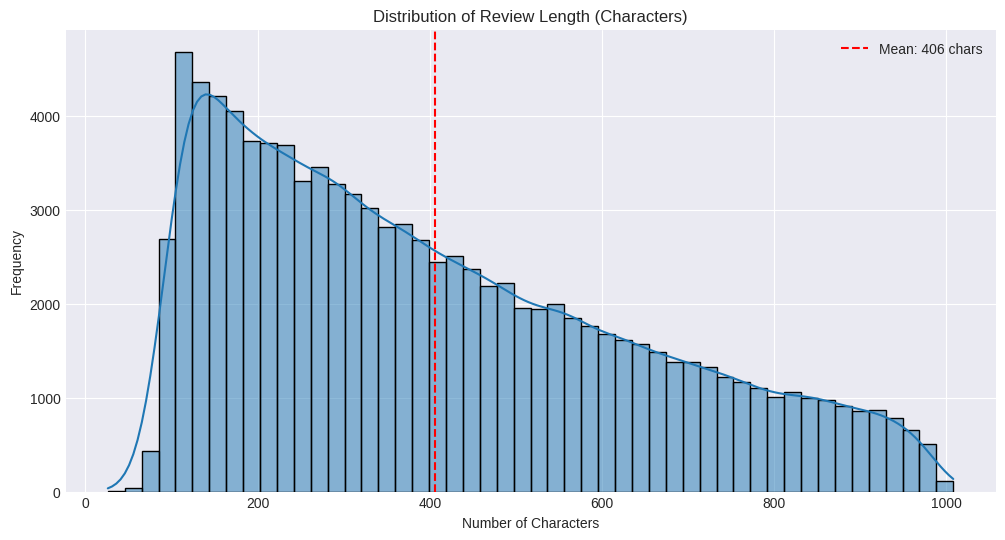

<ipython-input-25-746c24ebf412>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=train_df, palette='viridis')


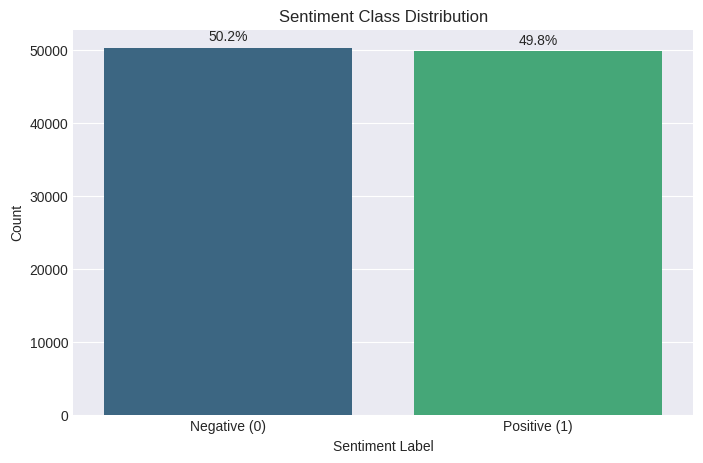

<ipython-input-25-746c24ebf412>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


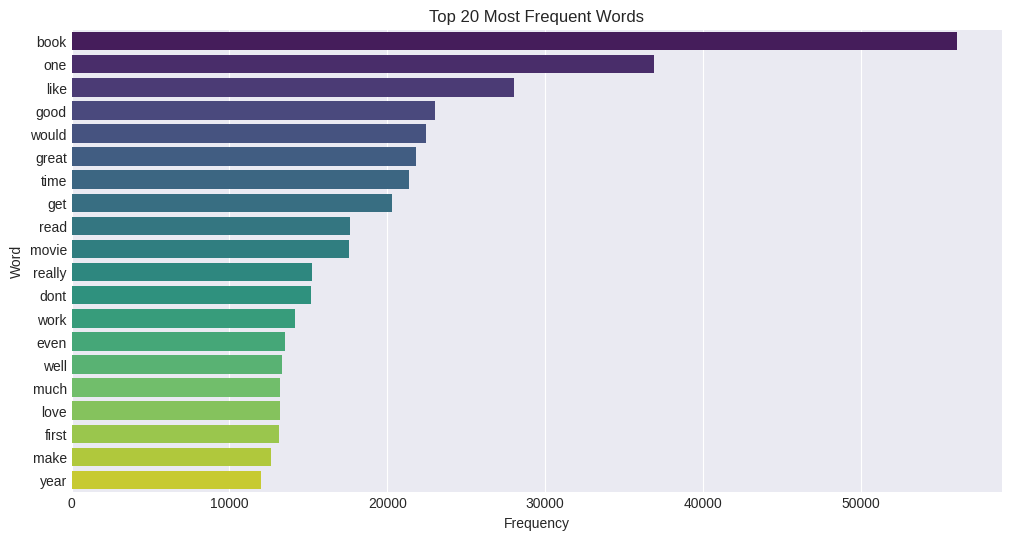

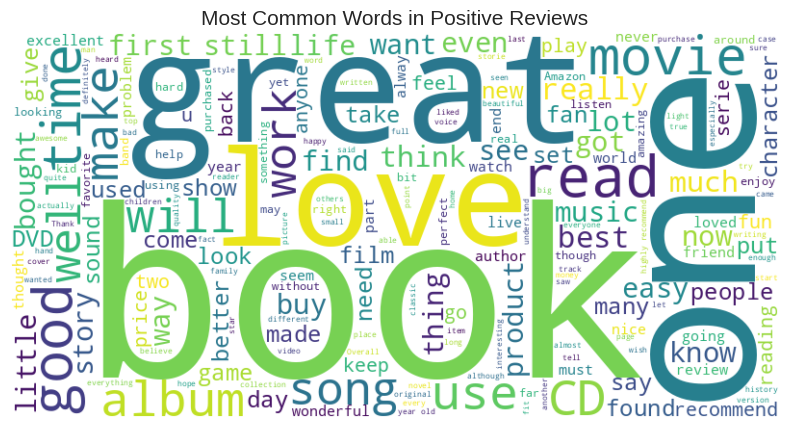

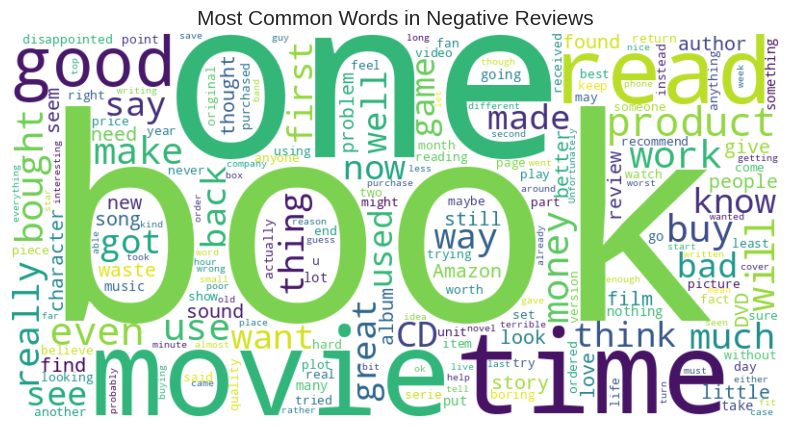

In [25]:

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Distribution of Review Length
train_df['review_length'] = train_df['content'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(train_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Length (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.axvline(train_df['review_length'].mean(), color='r', linestyle='--', label=f'Mean: {train_df["review_length"].mean():.0f} chars')
plt.legend()
plt.show()

# 2. Sentiment Class Distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=train_df, palette='viridis')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])

# Add percentages
total = len(train_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 0.01*total
    ax.annotate(percentage, (x, y), ha='center')
plt.show()

# 3. Top 20 Most Frequent Words
def get_top_words(text_series, n=20):
    all_words = ' '.join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Using processed text if available, otherwise raw content
text_source = train_df['processed_text'] if 'processed_text' in train_df.columns else train_df['content']
top_words = get_top_words(text_source)

plt.figure(figsize=(12, 6))
words, counts = zip(*top_words)
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# 4. Word Clouds by Sentiment
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, size=15)
    plt.axis('off')
    plt.show()

# Positive reviews
positive_text = ' '.join(train_df[train_df['label'] == 1]['content'])
plot_wordcloud(positive_text, 'Most Common Words in Positive Reviews')

# Negative reviews
negative_text = ' '.join(train_df[train_df['label'] == 0]['content'])
plot_wordcloud(negative_text, 'Most Common Words in Negative Reviews')

# Preprocessing


In [6]:
# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [8]:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [9]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Remove extra whitespace
    text = re.sub(' +', ' ', text)
    # Tokenize
    words = text.split()
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [10]:
# Apply preprocessing
train_df['processed_text'] = train_df['content'].apply(preprocess_text)
test_df['processed_text'] = test_df['content'].apply(preprocess_text)

# Check processed text
print("\nSample processed text:")
print(train_df['processed_text'].iloc[0])


Sample processed text:
pretty people film even rudy character played michael madsen adapted jim thompson novel cryin loud supposed marginal character fashion model though mcqueen mcgraw attractive check mcqueens crummy prison haircut believable role baldwin bassinger seem like movie star trying act like hard case action wise robbery scene pekinpah version time exciting suspenseful anything remake


# Tokenization and Sequence Preparation

In [11]:
# Tokenization
max_words = 10000  # Vocabulary size
max_len = 200      # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['processed_text'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df['processed_text'])
X_test = tokenizer.texts_to_sequences(test_df['processed_text'])

# Pad sequences to ensure uniform length
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# Prepare labels
y_train = train_df['label'].values
y_test = test_df['label'].values

print("\nSample sequence:")
print(X_train[0])
print(f"\nSequence shapes - Train: {X_train.shape}, Test: {X_test.shape}")


Sample sequence:
[ 146   53   79   15    1   52  395 1082    1 7271 2518 4693  185    1
  754  563 7170   52 2054  451  117    1    1 2055  483    1    1 3245
 9486 1577  948 9963    1  319    4   11   90  204  964    4  104  229
  350 2353    1  267    1  128    8 1058 3653  147 2113    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    

# LSTM Model

In [15]:
# Model parameters
embedding_dim = 128
lstm_units = 72
dropout_rate = 0.2

# Build the model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),  # Removed input_length
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(LSTM(lstm_units)),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Explicitly build the model with input shape
model.build(input_shape=(None, max_len))  # This will properly initialize the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 144)       │       115,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200, 144)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 144)            │       124,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,530,113 (5.84 MB)

 Trainable params: 1,530,113 (5.84 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Enhanced training parameters
batch_size = 128  # Increased to speed up training
epochs = 15  # Increased to allow more patience
validation_split = 0.2

# Enhanced early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased patience
    restore_best_weights=True,
    min_delta=0.001  # Minimum improvement required
)

# Add learning rate reduction
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[early_stopping, reduce_lr],  # Added reduce_lr
    verbose=1
)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1285s 2s/step - accuracy: 0.7600 - loss: 0.4745 - val_accuracy: 0.8536 - val_loss: 0.3312 - learning_rate: 0.0010
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1297s 2s/step - accuracy: 0.8821 - loss: 0.2822 - val_accuracy: 0.8558 - val_loss: 0.3292 - learning_rate: 0.0010
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1213s 2s/step - accuracy: 0.9094 - loss: 0.2304 - val_accuracy: 0.8535 - val_loss: 0.3576 - learning_rate: 0.0010
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1320s 2s/step - accuracy: 0.9328 - loss: 0.1777 - val_accuracy: 0.8418 - val_loss: 0.4364 - learning_rate: 0.0010
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1291s 2s/step - accuracy: 0.9490 - loss: 0.1380 - val_accuracy: 0.8456 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1291s 2s/step - accuracy: 0.9643 - loss: 0.1029 - val_accuracy: 0.8377 - val_loss: 0.5214 - learning_rate: 0.0010
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1308s 2s/step - accuracy: 0.9731 - l

625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step
Precision: 0.8531
Recall: 0.8559
F1 Score: 0.8545
Average Precision: 0.9305

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85      9961
    Positive       0.85      0.86      0.85     10039

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000



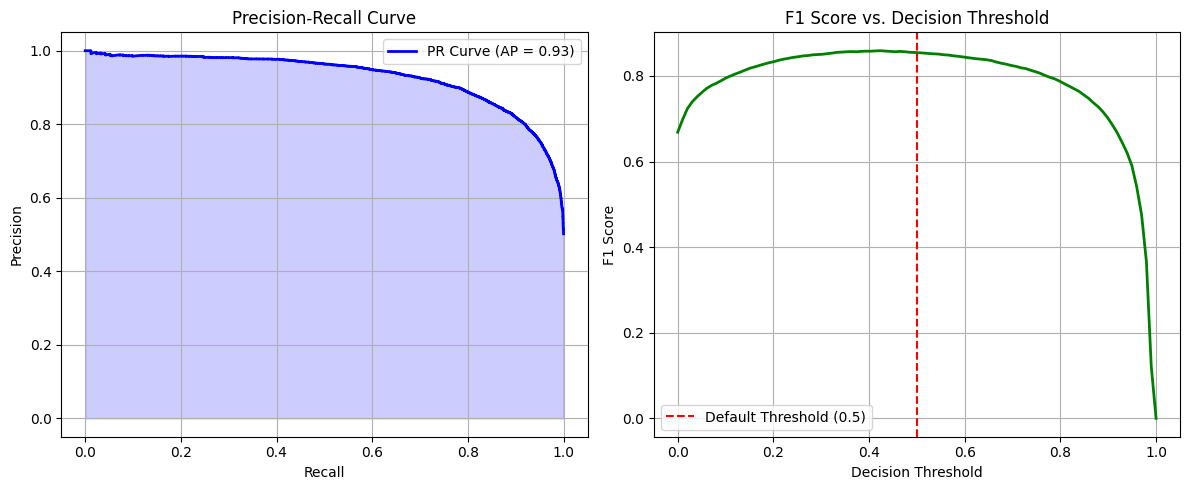


Key Insights:
- Precision: Measures how many predicted positives are truly positive (Higher = fewer false positives)
- Recall: Measures how many actual positives were caught (Higher = fewer false negatives)
- F1: Harmonic mean of precision and recall (Best when both matter equally)
- Average Precision: Summary of PR curve (Higher = better overall performance)
- Optimal Threshold: Check where F1 peaks in right plot (may not be at 0.5)


In [19]:
# Precision, Recall, and F1 Evaluation Cell
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt # Ensure plt is imported for plotting
import numpy as np # Ensure numpy is imported for array operations

def evaluate_prf1(model, X_test, y_test):
    # Generate predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    ap = average_precision_score(y_test, y_pred_prob)  # Average precision

    # Classification report with zero_division handled
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], zero_division=1)

    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Precision: {ap:.4f}")
    print("\nDetailed Classification Report:")
    print(report)

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)

    plt.figure(figsize=(12, 5))

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 1)
    plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR Curve (AP = {ap:.2f})')
    plt.fill_between(recall_curve, precision_curve, alpha=0.2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.grid(True)

    # F1 Score Threshold Analysis
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_test, (y_pred_prob > t).astype(int)) for t in thresholds]

    plt.subplot(1, 2, 2)
    plt.plot(thresholds, f1_scores, color='green', lw=2)
    plt.axvline(x=0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
    plt.xlabel('Decision Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Decision Threshold')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Return metrics
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'average_precision': ap,
        'classification_report': report,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve,
        'f1_thresholds': thresholds,
        'f1_scores': f1_scores
    }

# Run evaluation
prf1_results = evaluate_prf1(model, X_test, y_test)

# Additional Interpretation
print("\nKey Insights:")
print("- Precision: Measures how many predicted positives are truly positive (Higher = fewer false positives)")
print("- Recall: Measures how many actual positives were caught (Higher = fewer false negatives)")
print("- F1: Harmonic mean of precision and recall (Best when both matter equally)")
print("- Average Precision: Summary of PR curve (Higher = better overall performance)")
print("- Optimal Threshold: Check where F1 peaks in right plot (may not be at 0.5)")

In [20]:
# Prediction Cell with Probability Scores
def predict_sentiment(model, tokenizer, reviews, max_len=200):
    """Predict sentiment for new reviews with probability scores"""

    # Preprocess the new reviews
    processed_reviews = [preprocess_text(review) for review in reviews]

    # Convert text to sequences and pad them
    sequences = tokenizer.texts_to_sequences(processed_reviews)
    X_new = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Get predictions and probabilities
    predictions = model.predict(X_new)
    probs = np.concatenate([1 - predictions, predictions], axis=1)  # [prob_negative, prob_positive]

    return [
        {
            "review": review,
            "prediction": "POSITIVE" if pred > 0.5 else "NEGATIVE",
            "confidence": max(prob[1], 1 - prob[1]),  # Highest probability between the two classes
            "prob_negative": float(prob[0]),  # Convert numpy float to Python float
            "prob_positive": float(prob[1]),
            "interpretation": "Strong positive" if prob[1] > 0.9 else
                             "Positive" if prob[1] > 0.7 else
                             "Neutral" if 0.4 <= prob[1] <= 0.6 else
                             "Negative" if prob[1] > 0.3 else
                             "Strong negative"
        }
        for review, pred, prob in zip(reviews, predictions, probs)
    ]

# Sample reviews to predict
new_reviews = [
    "This product is amazing! Worth every penny.",
    "Terrible quality, broke after 2 days.",
    "It's okay but not what I expected.",
    "Absolutely love it! Best purchase this year.",
    "Waste of money. Doesn't work as advertised."
]

# Make predictions
predictions = predict_sentiment(model, tokenizer, new_reviews)

# Display results
print("Sentiment Predictions with Confidence Scores:")
for i, pred in enumerate(predictions, 1):
    print(f"\nReview {i}: {pred['review']}")
    print(f"Prediction: {pred['prediction']} ({pred['interpretation']})")
    print(f"Confidence: {pred['confidence']:.2%}")
    print(f"P(Negative): {pred['prob_negative']:.4f}")
    print(f"P(Positive): {pred['prob_positive']:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
Sentiment Predictions with Confidence Scores:

Review 1: This product is amazing! Worth every penny.
Prediction: POSITIVE (Strong positive)
Confidence: 97.54%
P(Negative): 0.0246
P(Positive): 0.9754

Review 2: Terrible quality, broke after 2 days.
Prediction: NEGATIVE (Strong negative)
Confidence: 98.46%
P(Negative): 0.9846
P(Positive): 0.0154

Review 3: It's okay but not what I expected.
Prediction: NEGATIVE (Strong negative)
Confidence: 79.37%
P(Negative): 0.7937
P(Positive): 0.2063

Review 4: Absolutely love it! Best purchase this year.
Prediction: POSITIVE (Strong positive)
Confidence: 97.57%
P(Negative): 0.0243
P(Positive): 0.9757

Review 5: Waste of money. Doesn't work as advertised.
Prediction: NEGATIVE (Strong negative)
Confidence: 99.09%
P(Negative): 0.9909
P(Positive): 0.0091


In [21]:
# Controversial Cases Evaluation Cell
import pandas as pd

def predict_with_confidence(model, tokenizer, reviews, max_len=200):
    """Predict sentiment with confidence scores for DataFrame output"""
    processed_reviews = [preprocess_text(review) for review in reviews]
    sequences = tokenizer.texts_to_sequences(processed_reviews)
    X_new = pad_sequences(sequences, maxlen=max_len, padding='post')

    predictions = model.predict(X_new)
    probs = np.concatenate([1 - predictions, predictions], axis=1)

    return [
        {
            "review": review,
            "prediction": "NEGATIVE" if pred < 0.5 else "POSITIVE",
            "confidence": max(prob[0], prob[1]),
            "prob_negative": float(prob[0]),
            "prob_positive": float(prob[1])
        }
        for review, pred, prob in zip(reviews, predictions, probs)
    ]

# Test controversial cases
controversial = [
    "Not bad for the price",
    "I don't hate it but would never recommend",
    "Meh, it's fine",
    "It works but I expected better",
    "Good enough I guess"
]

# Generate predictions and display as DataFrame
controversial_predictions = predict_with_confidence(model, tokenizer, controversial)
print(pd.DataFrame(controversial_predictions))

# Add interpretation analysis
print("\nControversial Case Analysis:")
for idx, pred in enumerate(controversial_predictions, 1):
    print(f"\nCase {idx}: '{pred['review']}'")
    print(f"Model is {pred['confidence']:.1%} confident it's {pred['prediction']}")
    if 0.4 < pred['prob_positive'] < 0.6:
        print("→ This appears to be a truly ambiguous case")
    elif (pred['prediction'] == "POSITIVE" and pred['prob_negative'] > 0.3) or \
         (pred['prediction'] == "NEGATIVE" and pred['prob_positive'] > 0.3):
        print("→ Model shows uncertainty despite prediction")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
                                      review prediction  confidence  \
0                      Not bad for the price   NEGATIVE    0.671983   
1  I don't hate it but would never recommend   NEGATIVE    0.907444   
2                             Meh, it's fine   POSITIVE    0.776180   
3             It works but I expected better   NEGATIVE    0.581819   
4                        Good enough I guess   NEGATIVE    0.514261   

   prob_negative  prob_positive  
0       0.671983       0.328017  
1       0.907444       0.092556  
2       0.223820       0.776180  
3       0.581819       0.418181  
4       0.514261       0.485739  

Controversial Case Analysis:

Case 1: 'Not bad for the price'
Model is 67.2% confident it's NEGATIVE
→ Model shows uncertainty despite prediction

Case 2: 'I don't hate it but would never recommend'
Model is 90.7% confident it's NEGATIVE

Case 3: 'Meh, it's fine'
Model is 77.6% confident it's POSITIVE

Case 4: 'It works but I ex